# load libraries

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **load dataset**

In [3]:
import scipy.io 
label_path = '/content/drive/MyDrive/HW2_datasets/lsp_dataset/joints.mat'
mat = scipy.io.loadmat(label_path)
ground_truth = mat['joints']
ground_truth = np.delete(ground_truth, 2, 0)  # delate rows of zeros

In [4]:
dataset = np.zeros((2000, 227, 227, 3), dtype=np.int32)
Ny = np.zeros(ground_truth.shape)
img_path = '/content/drive/MyDrive/HW2_datasets/lsp_dataset/images'
img_names = os.listdir(img_path)
img_names.sort()
for i, img_name in enumerate(img_names):
  path = img_path + '/' + img_name
  img = cv2.imread(path)[:,:,::-1]
  # normalization
  bh = img.shape[0]
  bw = img.shape[1]
  bc = np.array([[bw/2], [bh/2]])
  y = ground_truth[:, :, i]
  Ny[:, :, i] = np.matmul(np.array([[1/bw, 0], [0, 1/bh]]), y-bc)
  img = cv2.resize(img, (227, 227))
  dataset[i, :, :, :] = img

In [5]:
def posture(joints):
  styles = ['c', 'r', 'r--', 'c--', 'g', 'b', 'b--', 'g--', 'm']
  indexes = [0, 1, 3, 4, 6, 7, 9, 10, 12]
  x = joints[0, :]
  y = joints[1, :]
  for index, style in zip(indexes, styles):
    plt.plot(x[index:index+2], y[index:index+2], style, linewidth=2)
  x_mean = (x[2] + x[3]) / 2
  y_mean = (y[2] + y[3]) / 2
  plt.plot([x_mean, x[12]], [y_mean, y[12]], 'y', linewidth=2)

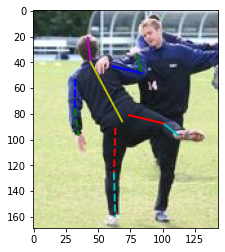

In [ ]:
img_path = '/content/drive/MyDrive/HW2_datasets/lsp_dataset/images'
img = cv2.imread(img_path+'/im1029.jpg')[:,:,::-1]
plt.imshow(img)
posture(ground_truth[:, :, 1028])

In [6]:
y = Ny.transpose((2, 1, 0)).reshape((2000, -1))

In [ ]:
X_train = dataset[0:1700, :, :, :]/255
y_train = y[0:1700, :]
X_test = dataset[1700:2000, :, :, :]/255
y_test = y[1700:2000, :]

AlexNet implementation

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.6),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.6),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(28)
])

In [ ]:
model.compile(loss='mse', metrics=['mse'], optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4))

In [ ]:
history = model.fit(x=X_train,
          y=y_train,
          batch_size=128,
          epochs=210,
          validation_split=0.15, 
          )

Epoch 1/210
12/12 [==============================] - 17s 834ms/step - loss: 1.9469 - mse: 1.9469 - val_loss: 1.1060 - val_mse: 1.1060
Epoch 2/210
12/12 [==============================] - 4s 297ms/step - loss: 1.7689 - mse: 1.7689 - val_loss: 1.6980 - val_mse: 1.6980
Epoch 3/210
12/12 [==============================] - 4s 308ms/step - loss: 1.5313 - mse: 1.5313 - val_loss: 0.4404 - val_mse: 0.4404
Epoch 4/210
12/12 [==============================] - 4s 298ms/step - loss: 1.3911 - mse: 1.3911 - val_loss: 0.2308 - val_mse: 0.2308
Epoch 5/210
12/12 [==============================] - 4s 297ms/step - loss: 1.2117 - mse: 1.2117 - val_loss: 0.3216 - val_mse: 0.3216
Epoch 6/210
12/12 [==============================] - 4s 298ms/step - loss: 1.0939 - mse: 1.0939 - val_loss: 0.3990 - val_mse: 0.3990
Epoch 7/210
12/12 [==============================] - 4s 301ms/step - loss: 1.0124 - mse: 1.0124 - val_loss: 0.5891 - val_mse: 0.5891
Epoch 8/210
12/12 [==============================] - 4s 298ms/step -

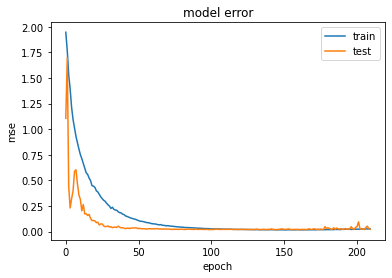

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
model.evaluate(x = X_test, y = y_test)

10/10 [==============================] - 1s 103ms/step - loss: 0.0217 - mse: 0.0217


[0.021674929186701775, 0.021674929186701775]

In [9]:
def myreshape(predicted_joint, img):
  predicted_joint = predicted_joint.reshape((28, ))
  index = np.array([i for i in range(14)])
  x_pos = predicted_joint[2*index].reshape((1, 14))
  y_pos = predicted_joint[2*index+1].reshape((1, 14))
  tt = np.concatenate((x_pos, y_pos), axis=0)
  bh = img.shape[0]
  bw = img.shape[1]
  bc = np.array([[bw/2], [bh/2]])
  y_predicted = np.matmul(np.array([[bw, 0], [0, bh]]), tt) + bc 
  return y_predicted

# PCP criterion

In [10]:
predictions = model.predict(dataset/255)

In [21]:
predicted_joints = np.zeros((2000, 2, 14))
for i, img_name in enumerate(img_names):
  path = img_path + '/' + img_name
  img = cv2.imread(path)[:,:,::-1]
  predicted_joints[i, :, :] = myreshape(predictions[i, :], img)


In [22]:
limb_lengths = np.zeros((2000, 10))
indexes = [0, 1, 3, 4, 6, 7, 9, 10, 12]
for i in range(2000):
  indexes = [0, 1, 3, 4, 6, 7, 9, 10, 12]
  x = ground_truth[0, :, i]
  y = ground_truth[1, :, i]
  for j, k in enumerate(indexes):
      limb_lengths[i, j] = np.sqrt((x[k]-x[k+1])**2 + (y[k]-y[k+1])**2)
  x_mean = (x[2] + x[3]) / 2
  y_mean = (y[2] + y[3]) / 2
  limb_lengths[i, 9] = np.sqrt((x[12]-x_mean)**2 + (y[12]-y_mean)**2)

In [23]:
distances = np.zeros((2000, 10))
for i in range(2000):
  x_predict = predicted_joints[i, 0, :]
  y_predict = predicted_joints[i, 1, :]
  x_actual = ground_truth[0, :, i]
  y_actual = ground_truth[1, :, i]
  indexes = [0, 1, 3, 4, 6, 7, 9, 10, 12]
  for j, k in enumerate(indexes):
    d_joint1 = np.sqrt((x_predict[k] - x_actual[k])**2 + (y_predict[k] - y_actual[k])**2)
    d_joint2 = np.sqrt((x_predict[k+1] - x_actual[k+1])**2 + (y_predict[k+1] - y_actual[k+1])**2)
    d_total = d_joint1 + d_joint2
    distances[i, j] = d_total
  x_mean_predicted = (x_predict[2] + x_predict[3]) / 2
  y_mean_predicted = (y_predict[2] + y_predict[3]) / 2
  x_mean_actual = (x_actual[2] + x_actual[3]) / 2
  y_mean_actual = (y_actual[2] + y_actual[3]) / 2
  d_joint1 = np.sqrt((x_mean_predicted - x_mean_actual)**2 + (y_mean_predicted - y_mean_actual)**2)
  d_joint2 = np.sqrt((x_predict[12] - x_actual[13])**2 + (y_predict[13] - y_actual[13])**2)
  d_total = d_joint1 + d_joint2
  distances[i, 9] = d_total

In [24]:
temp = distances < limb_lengths / 2
PCP = temp.sum(axis = 0) / 2000
PCP

array([0.29  , 0.374 , 0.3865, 0.249 , 0.0085, 0.0805, 0.1085, 0.0145,
       0.1185, 0.631 ])

Text(0, 0.5, 'PCP')

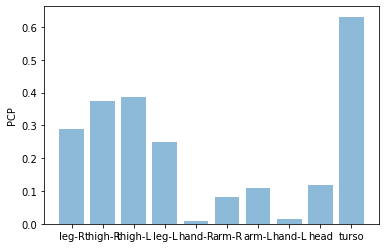

In [26]:
objects = ['leg-R', 'thigh-R', 'thigh-L', 'leg-L', 'hand-R', 'arm-R', 'arm-L', 'hand-L', 'head', 'turso']
y_pos = np.arange(len(objects))
plt.bar(y_pos, PCP, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('PCP')


## PDJ criterion

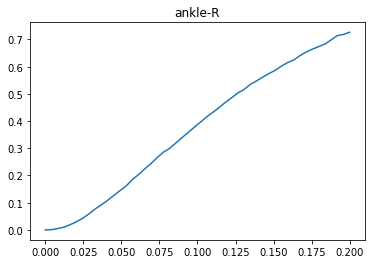

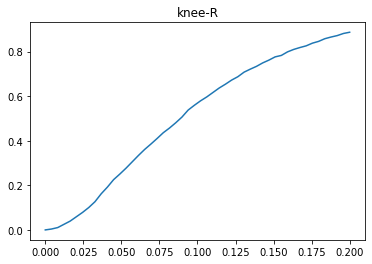

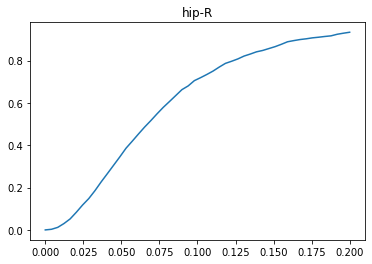

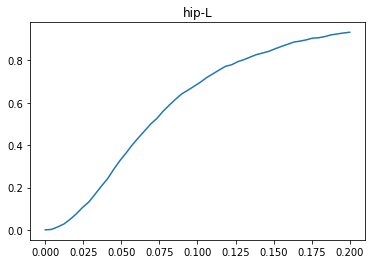

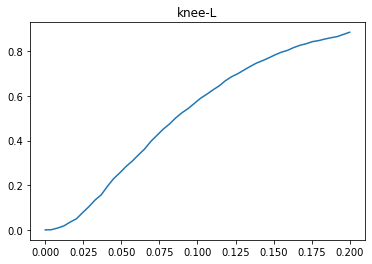

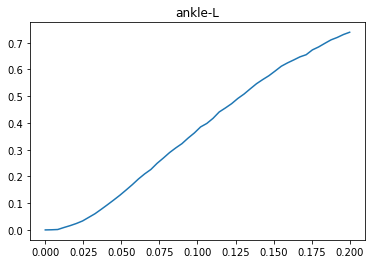

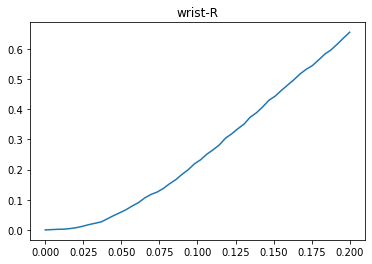

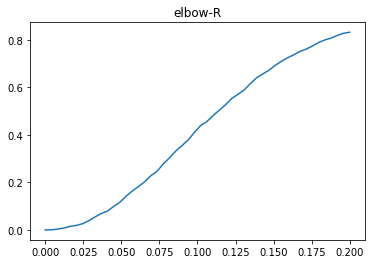

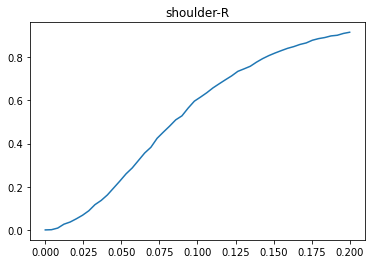

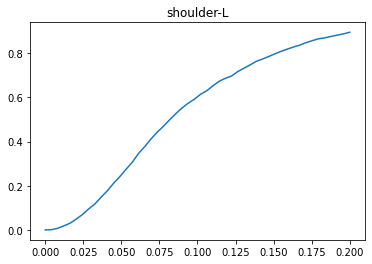

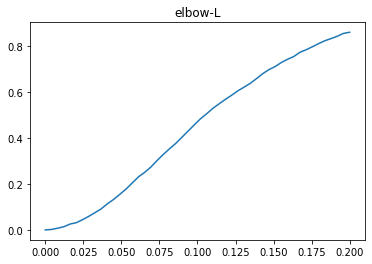

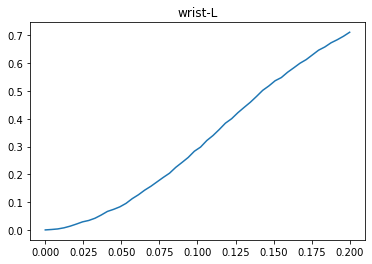

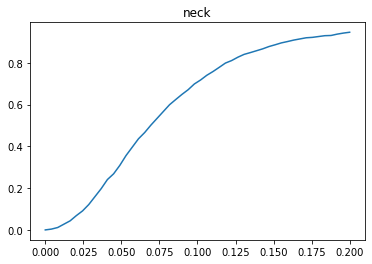

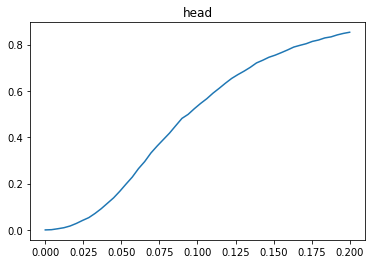

In [ ]:
y = Ny.transpose((2, 1, 0)).reshape((2000, -1))
squares = (predictions - y) ** 2
distances = np.zeros((2000, 14))
for i in range(14):
  distances[:, i] = np.sqrt(squares[:, 2*i]+squares[:, 2*i+1])

thrs = np.linspace(0, 0.2)
PDJ = np.zeros(thrs.shape)
joints = ['ankle-R', 'knee-R', 'hip-R', 'hip-L', 'knee-L', 'ankle-L', 'wrist-R', 'elbow-R', 'shoulder-R', 'shoulder-L',\
          'elbow-L', 'wrist-L', 'neck', 'head']
for i in range(14):
  for j, thr in enumerate(thrs):
    PDJ[j] = (distances[:, i] < thr).sum() / 2000
  plt.figure()
  plt.plot(thrs, PDJ)
  plt.title(joints[i])

# Work Space

In [ ]:
print(predictions.shape)
print(y.shape)
print(ground_truth.shape)
print(limb_lengths.shape)
print(thrs.shape)

(2000, 28)
(2000, 28)
(2, 14, 2000)
(2000, 10)
(50,)


In [ ]:
model.save('/content/drive/MyDrive/checkpoints1/my_checkpoint')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoints1/my_checkpoint/assets


In [7]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/checkpoints1/my_checkpoint')

(-0.5, 69.5, 159.5, -0.5)

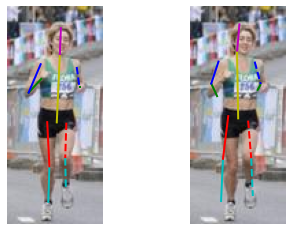

In [15]:
img_path = '/content/drive/MyDrive/HW2_datasets/lsp_dataset/images'
plt.subplot(1, 2, 1)
img = cv2.imread(img_path+'/im0001.jpg')[:,:,::-1]
plt.imshow(img)
plt.axis('off')
posture(ground_truth[:, :, 0])
plt.subplot(1, 2, 2)
plt.imshow(img)
posture(myreshape(predictions[0, :], img))
plt.axis('off')

(-0.5, 144.5, 200.5, -0.5)

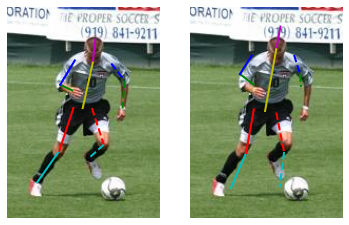

In [16]:
img_path = '/content/drive/MyDrive/HW2_datasets/lsp_dataset/images'
plt.subplot(1, 2, 1)
img = cv2.imread(img_path+'/im0002.jpg')[:,:,::-1]
plt.imshow(img)
plt.axis('off')
posture(ground_truth[:, :, 1])
plt.subplot(1, 2, 2)
plt.imshow(img)
posture(myreshape(predictions[1, :], img))
plt.axis('off')

(-0.5, 89.5, 177.5, -0.5)

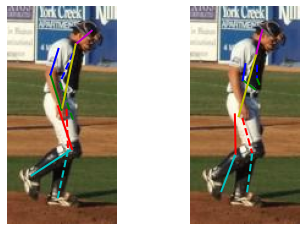

In [18]:
img_path = '/content/drive/MyDrive/HW2_datasets/lsp_dataset/images'
plt.subplot(1, 2, 1)
img = cv2.imread(img_path+'/im0004.jpg')[:,:,::-1]
plt.imshow(img)
plt.axis('off')
posture(ground_truth[:, :, 3])
plt.subplot(1, 2, 2)
plt.imshow(img)
posture(myreshape(predictions[3, :], img))
plt.axis('off')

(-0.5, 101.5, 174.5, -0.5)

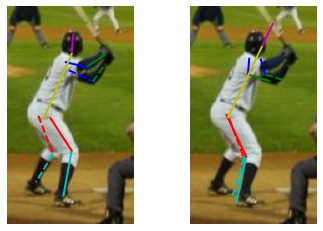

In [19]:
img_path = '/content/drive/MyDrive/HW2_datasets/lsp_dataset/images'
plt.subplot(1, 2, 1)
img = cv2.imread(img_path+'/im0005.jpg')[:,:,::-1]
plt.imshow(img)
plt.axis('off')
posture(ground_truth[:, :, 4])
plt.subplot(1, 2, 2)
plt.imshow(img)
posture(myreshape(predictions[4, :], img))
plt.axis('off')